Until now we have been training the model with png spectrograms, which are colour images and therefor have 3 channels. The colour is just a color map, it doesn't actually mean anything, so we might as well train with the raw spectrogram values. 

I calculated the spectrograms and saved them all as .npy files, so I'll need to figure out how to get those into the data loader, then change the input channels to 1. 



In [ ]:
# Import necessary libraries.
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display
import pandas as pd
import seaborn as sns


In [ ]:
pip install torchaudio


     |████████████████████████████████| 1.9 MB 8.0 MB/s 


In [ ]:
import torchaudio

In [ ]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()

In [ ]:
device = set_device()

GPU is enabled in this notebook.


## Download Dataset

In [ ]:
#@title Default title text
import requests

fname = "music.zip"
url = "https://osf.io/drjhb/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [ ]:
from zipfile import ZipFile

with ZipFile(fname, 'r') as zipObj:
  # Extract all the contents of zip file in different directory
  zipObj.extractall()

## Make Mel Spectrograms with Librosa

In [ ]:
in_folder_path = "/content/Data/genres_original/"
out_folder_path = "/content/spectrograms_30s/" #change this for your personal drive. 

if not os.path.exists(out_folder_path):
    os.mkdir(out_folder_path)

#get list of genre folders
genre_folders = glob.glob(in_folder_path + "*")

#initialize empty list of problem files:
problem_files = []

#loop over genre folders
for genre_folder in genre_folders: 
  #get list of individual .wav files
  wav_files = glob.glob(genre_folder + "/*.wav")

  #get output folder path
  genre_name = genre_folder.split('/')[-1]
  print(genre_name)
  out_folder = out_folder_path + genre_name + "/"
  #make output folder if it doesn't exist
  if not os.path.exists(out_folder):
    os.mkdir(out_folder)

  #loop over list of wav files
  for wav_file in wav_files:
    #extract file name
    file_name = wav_file.split('/')[-1]
    file_name = file_name.strip(".wav")
    
    #load wav file
    try: 
      y, sr = librosa.load(wav_file)

      #normalize audio
      y = (y - y.mean())/ y.std()

      #calculate mel spectrogram
      spectrogram = librosa.feature.melspectrogram(y, sr = sr)
      spectrogram_db = librosa.amplitude_to_db(spectrogram, ref = np.max)

      #global normalization of the spectrogram (not frequency band normalization...)
      spectrogram_norm = (spectrogram_db - spectrogram_db.mean()) / spectrogram_db.std()

      #save spectrogram
      np.save(out_folder + file_name, spectrogram_norm)

    except:
      print("Something is wrong with " + file_name + "so it has been skipped")
      problem_files = problem_files.append(wav_file)

reggae
disco
country
pop
blues
rock
hiphop
metal
jazz


/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


Something is wrong with jazz.00054so it has been skipped
classical


## Split training and test data

In [ ]:
## EDIT HERE TO CHANGE SIZE OF TEST AND VAL DATASETS
test_prop = 0.15
val_prop = 0.15

train_prop = 1 - test_prop - val_prop

# Create folder with training, testing and validation data.

spectrograms_dir = "/content/spectrograms_30s/"
folder_names = ['/content/train/', 
                '/content/test/', 
                '/content/val/']
train_dir = folder_names[0]
test_dir = folder_names[1]
val_dir = folder_names[2]

for f in folder_names:
  if os.path.exists(f):
    shutil.rmtree(f)
    os.mkdir(f)
  else:
    os.mkdir(f)

# Loop over all genres.

genres = list(os.listdir(spectrograms_dir))
for g in genres:
  # find all images & split in train, test, and validation
  src_file_paths= []
  for im in glob.glob(os.path.join(spectrograms_dir, f'{g}',"*.npy"), recursive=True):
    src_file_paths.append(im)
  random.shuffle(src_file_paths)

  test_idx = int(len(src_file_paths) * test_prop)
  val_idx = test_idx + int(len(src_file_paths) * val_prop)

  test_files = src_file_paths[0:test_idx]
  val_files = src_file_paths[test_idx:val_idx]
  train_files = src_file_paths[val_idx:]

  #  make destination folders for train and test images
  for f in folder_names:
    if not os.path.exists(os.path.join(f + f"{g}")):
      os.mkdir(os.path.join(f + f"{g}"))

  # copy training and testing images over
  for f in train_files:
    shutil.copy(f, os.path.join(os.path.join(train_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in test_files:
    shutil.copy(f, os.path.join(os.path.join(test_dir + f"{g}") + '/',os.path.split(f)[1]))
  for f in val_files:
    shutil.copy(f, os.path.join(os.path.join(val_dir + f"{g}") + '/',os.path.split(f)[1]))

## Apply sliding window to data

In [ ]:
def apply_sliding_window(in_dir, out_dir, window_length = 3, hop_length = 1, 
                         save_as_tensor = False):
  #IMPORTANT NOTE - this function assumes that the spectrograms were made with 
    #default librosa nfft_size, hop_length, etc. 

    #window and hop length units are in seconds. 

  window_size = librosa.time_to_frames(window_length)
  hop_size = librosa.time_to_frames(hop_length)
  #get list of genre folders
  genre_folders = glob.glob(in_dir + "*")

  #make out_dir if it doesn't exist
  if not os.path.exists(out_dir):
    os.mkdir(out_dir)

  #loop over genre folders
  for genre_folder in genre_folders:

    #get list of individual spectrogram files
    spec_files = glob.glob(genre_folder + "/*.npy")

    #get output folder path
    genre_name = genre_folder.split('/')[-1]
    out_folder = out_dir + genre_name + "/"
    print(out_folder)
    #make output folder if it doesn't exist

    if not os.path.exists(out_folder):
      os.mkdir(out_folder)

    #loop over spectrogram files
    for spec_file in spec_files:
      #extract file name
      file_name = spec_file.split('/')[-1]
      file_name = file_name.strip(".npy")

      #load spectrogram
      spec = np.load(spec_file)
      
      #apply sliding frame to spectrogram
      all_frames = librosa.util.frame(spec, window_size, hop_size)
      all_frames = np.moveaxis(all_frames, 2, 0)

      #loop over individual frames
      for i, frame in enumerate(all_frames):
        
        #specify out file name
        full_out_path = out_folder + file_name + "_" + str(i)
        
        if save_as_tensor: 
          #convert np array to tensor
          torch_frame = torch.from_numpy(frame)
          #save torch of spectrogram frame
          torch.save(torch_frame, full_out_path + ".pt")  

        else: 
          #save spectrogram frame
          np.save(full_out_path, frame)

In [ ]:
# Cut Data 
full_path = '/content/'

apply_sliding_window(full_path + 'test/*', full_path + 'test_cropped/', save_as_tensor=True)
apply_sliding_window(full_path + 'train/*', full_path + 'train_cropped/', save_as_tensor=True)
apply_sliding_window(full_path + 'val/*', full_path + 'val_cropped/', save_as_tensor = True)

/content/test_cropped/reggae/
/content/test_cropped/disco/


/usr/local/lib/python3.7/dist-packages/librosa/util/utils.py:200: UserWarning: librosa.util.frame called with axis=-1 on a non-contiguous input. This will result in a copy.
  "on a non-contiguous input. This will result in a copy.".format(axis)


/content/test_cropped/country/
/content/test_cropped/pop/
/content/test_cropped/blues/
/content/test_cropped/rock/
/content/test_cropped/hiphop/
/content/test_cropped/metal/
/content/test_cropped/jazz/
/content/test_cropped/classical/
/content/train_cropped/reggae/
/content/train_cropped/disco/
/content/train_cropped/country/
/content/train_cropped/pop/
/content/train_cropped/blues/
/content/train_cropped/rock/
/content/train_cropped/hiphop/
/content/train_cropped/metal/
/content/train_cropped/jazz/
/content/train_cropped/classical/
/content/val_cropped/reggae/
/content/val_cropped/disco/
/content/val_cropped/country/
/content/val_cropped/pop/
/content/val_cropped/blues/
/content/val_cropped/rock/
/content/val_cropped/hiphop/
/content/val_cropped/metal/
/content/val_cropped/jazz/
/content/val_cropped/classical/


## Dataloader - torch version

In [ ]:
# Data loading.
train_dir = "/content/train_cropped/"
val_dir =  "/content/val_cropped/"

train_dataset = datasets.DatasetFolder(
    train_dir, 
    extensions = (".pt"), 
    loader = torch.load )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

val_dataset = datasets.DatasetFolder(
    val_dir, 
    extensions = (".pt"), 
    loader = torch.load )

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

In [ ]:
# Data loading.
train_dir = "/content/train_cropped/"
val_dir =  "/content/val_cropped/"

train_dataset = datasets.DatasetFolder(
    train_dir, 
    extensions = (".pt"), 
    loader = torch.load, 
    transform = transforms.Compose([torchaudio.transforms.TimeMasking(time_mask_param= 40, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param=40, iid_masks=True), 
                                    torchaudio.transforms.TimeMasking(time_mask_param= 30, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param = 30, iid_masks=True), 
                                    torchaudio.transforms.TimeMasking(time_mask_param= 20, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param = 20, iid_masks=True)]) )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

val_dataset = datasets.DatasetFolder(
    val_dir, 
    extensions = (".pt"), 
    loader = torch.load )

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

Looks good! And we don't need the squeeze anymore. 

## Train Default Network

In [ ]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=0) # changed in channels to 1 
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=512, out_features=10) 
    # self.fc2 = nn.Linear(in_features=64, out_features=10)

    self.batchnorm1 = nn.BatchNorm2d(num_features=64)
    self.batchnorm2 = nn.BatchNorm2d(num_features=128)
    self.batchnorm3 = nn.BatchNorm2d(num_features=512)
    self.batchnorm4 = nn.BatchNorm2d(num_features=256)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.5, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.dropout(x)
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.dropout(x)
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    #print(x.shape)################################################################

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x)

    # # Fully connected layer 2.
    # x = self.dropout(x)
    # x = self.fc2(x)
    # x = F.softmax(x)

    return x


def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0025)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        
        #squeeze out extra dimension in data
        #data = data.squeeze(dim = 0) ########################################### this is new. 

        #using torch dataloader, you have to unsqueeze the data, I think...
        data = data.reshape((100, 1, 128, 129))#######  this is hardcoded for now and should be fixed somewhere else. 
        #100 is the batch size, 1 is for a single channel, and 128 by 129 is the size of the spectrogram image in pixels. 

        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        #using torch dataloader, you have to unsqueeze the data, I think...
        data = data.reshape((100, 1, 128, 129))#######  this is hardcoded for now and should be fixed somewhere else. 
        #100 is the batch size, 1 is for a single channel, and 128 by 129 is the size of the spectrogram image in pixels. 

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

In [ ]:
# this is the base code for a variational auto encoder for the MNIst data set
# see what modifications will be needed to be done
K_VAE = 2


class ConvVAE(nn.Module):
  def __init__(self, K, num_filters=32, filter_size=5):
    super(ConvVAE, self).__init__()

    # With padding=0, the number of pixels cut off from each image dimension
    # is filter_size // 2. Double it to get the amount of pixels lost in
    # width and height per Conv2D layer, or added back in per
    # ConvTranspose2D layer.
    filter_reduction = 2 * (filter_size // 2)

    # After passing input through two Conv2d layers, the shape will be
    # 'shape_after_conv'. This is also the shape that will go into the first
    # deconvolution layer in the decoder
    self.shape_after_conv = (num_filters,
                              data_shape[1]-2*filter_reduction,
                              data_shape[2]-2*filter_reduction)
    flat_size_after_conv = self.shape_after_conv[0] \
        * self.shape_after_conv[1] \
        * self.shape_after_conv[2]

    # Define the recognition model (encoder or q) part
    self.q_bias = BiasLayer(data_shape)
    self.q_conv_1 = nn.Conv2d(data_shape[0], num_filters, 5)
    self.q_conv_2 = nn.Conv2d(num_filters, num_filters, 5)
    self.q_flatten = nn.Flatten()
    self.q_fc_phi = nn.Linear(flat_size_after_conv, K+1)

    # Define the generative model (decoder or p) part
    self.p_fc_upsample = nn.Linear(K, flat_size_after_conv)
    self.p_unflatten = nn.Unflatten(-1, self.shape_after_conv)
    self.p_deconv_1 = nn.ConvTranspose2d(num_filters, num_filters, 5)
    self.p_deconv_2 = nn.ConvTranspose2d(num_filters, data_shape[0], 5)
    self.p_bias = BiasLayer(data_shape)

    # Define a special extra parameter to learn scalar sig_x for all pixels
    self.log_sig_x = nn.Parameter(torch.zeros(()))

  def infer(self, x):
    """Map (batch of) x to (batch of) phi which can then be passed to
    rsample to get z
    """
    s = self.q_bias(x)
    s = F.relu(self.q_conv_1(s))
    s = F.relu(self.q_conv_2(s))
    flat_s = s.view(s.size()[0], -1)
    phi = self.q_fc_phi(flat_s)
    return phi

  def generate(self, zs):
    """Map [b,n,k] sized samples of z to [b,n,p] sized images
    """
    # Note that for the purposes of passing through the generator, we need
    # to reshape zs to be size [b*n,k]
    b, n, k = zs.size()
    s = zs.view(b*n, -1)
    s = F.relu(self.p_fc_upsample(s)).view((b*n,) + self.shape_after_conv)
    s = F.relu(self.p_deconv_1(s))
    s = self.p_deconv_2(s)
    s = self.p_bias(s)
    mu_xs = s.view(b, n, -1)
    return mu_xs

  def decode(self, zs):
    # Included for compatability with conv-AE code
    return self.generate(zs.unsqueeze(0))

  def forward(self, x):
    # VAE.forward() is not used for training, but we'll treat it like a
    # classic autoencoder by taking a single sample of z ~ q
    phi = self.infer(x)
    zs = rsample(phi, 1)
    return self.generate(zs).view(x.size())

  def elbo(self, x, n=1):
    """Run input end to end through the VAE and compute the ELBO using n
    samples of z
    """
    phi = self.infer(x)
    zs = rsample(phi, n)
    mu_xs = self.generate(zs)
    return log_p_x(x, mu_xs, self.log_sig_x.exp()) - kl_q_p(zs, phi)


def expected_z(phi):
  return phi[:, :-1]


def rsample(phi, n_samples):
  """Sample z ~ q(z;phi)
  Ouput z is size [b,n_samples,K] given phi with shape [b,K+1]. The first K
  entries of each row of phi are the mean of q, and phi[:,-1] is the log
  standard deviation
  """
  b, kplus1 = phi.size()
  k = kplus1-1
  mu, sig = phi[:, :-1], phi[:,-1].exp()
  eps = torch.randn(b, n_samples, k, device=phi.device)
  return eps*sig.view(b,1,1) + mu.view(b,1,k)


def train_vae(vae, dataset, epochs=10, n_samples=1000):
  opt = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=0)
  elbo_vals = []
  vae.to(DEVICE)
  vae.train()
  loader = DataLoader(dataset, batch_size=250, shuffle=True, pin_memory=True)
  for epoch in trange(epochs, desc='Epochs'):
    for im, _ in tqdm(loader, total=len(dataset) // 250, desc='Batches', leave=False):
      im = im.to(DEVICE)
      opt.zero_grad()
      loss = -vae.elbo(im)
      loss.backward()
      opt.step()

      elbo_vals.append(-loss.item())
  vae.to('cpu')
  vae.eval()
  return elbo_vals


# trained_conv_VarAE = ConvVAE(K=K_VAE)
# elbo_vals = train_vae(trained_conv_VarAE, train_set, n_samples=10000)

# print(f'Learned sigma_x is {torch.exp(trained_conv_VarAE.log_sig_x)}')

# Uncomment below if you'd like to see the the training
# curve of the evaluated ELBO loss function
# ELBO is the loss function used to train VAEs (see lecture!)
# plt.figure()
# plt.plot(elbo_vals)
# plt.xlabel('Batch #')
# plt.ylabel('ELBO')
# plt.show()

In [ ]:
# train
net = ConvVAE(K_VAE).to(device)
elbo_vals = train_vae(net, train_loader, ephocs = 5, n_samples = 1000)

NameError: ignored

In [ ]:
# Run training.
net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 30)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

# Run training.
net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 30)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Very interesting! We reach high training accuracy in much fewer epochs here than we did with the original png dataset. I should note that I am also using a larger batch size here than there. Could that be having an effect? 

We reach that high accuracy on the training set without any of the 'bumps' that we saw when training on the png dataset for longer. Maybe that's a sign that I should stop focusing so much on the RSA and instead focus on reducing the overfitting with this model. 

Some ideas on reducing the overfitting: 
- Data augmentation
- More dropout
- L1 / L2 reglularization (doesn't seem to be included at the moment). 
- Reduce the complexity of the model (fewer layers, narrower layers). 
- early stopping (although based on the plots, that doesn't seem like it would make a difference.) 

The validation accuracy is also very noisy. I already made the validation set larger than before (15% instead of 10%). Is there anything else we can do about that? Is it something we should be worried about? 

# Experimenting with Regularization

Robert suggested that a good place to start would be simplifying the model. Strip it down to as few layers as possible until it can barely improve on the training set, then add complexity back in, looking for a sweetspot with good fit without massive overfitting. 


## Reducing number of layers

# Alex's Advice on Regularization: 

Here are some ideas of changes to the model with Alex's help: 

- Increase the stride to decrease computation time (thanks Zach!)

- Dropout after conv2D layer (thanks Courtnie!)

- Create a bottleneck shape for the channels (wide to narrow to wide) (thanks Alex!)
  - for example, instead of [1, 8, 32, 64, 128, 512] do [1, 64, 512, 128]. 

- Use only a subset of the training data for hyperparameter setting. That will make this iteration process faster. (thanks Alex!)

- Try increasing stride instead of max pooling. (thanks Alex)

- Play with learning rate a bit , but this is lower priority. (thanks Alex). 
  - Try a slightly lower learning rate. 

- More data augmentation should be priority #1. 

- With optimizers other than adam (simpler ones) learning rate decay usually improves accuracy. With adam it isn't so necessary. 
  - There are some cases where adam doesn't work so great. Hard to predict what those cases will be. Sometimes SGD + learning rate decay is better. It is usually about equally good to adam, but adam is simpler to set up because fewer parameters. 

-  Our next meeting with Alex will be on Thursday- same time. 


Here are some ideas about augmentation in a dataloader with Alex: 

- Most direct option is to write a dataloader that applies the windowing, the augmentation, the spectrograming, all at the dataloader phase. 

- Another option would be to apply the transformation in the frequency domain, so that we apply the augmentations on the spectrograms, not the signal. 
  - this might be the better option, because it will be faster (don't need to fft every time). 


### Bottle Neck Shape of Network

I'm going to use the same number of layers as the original network, but make the filter size get wide --> small --> big. 

In [ ]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0) # changed in channels to 1 
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=512, out_features=10) ##################################### changed in_features

    self.batchnorm1 = nn.BatchNorm2d(num_features=16)
    self.batchnorm2 = nn.BatchNorm2d(num_features=64)
    self.batchnorm3 = nn.BatchNorm2d(num_features=128)
    self.batchnorm4 = nn.BatchNorm2d(num_features=512)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.3, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    #print(x.shape)################################################################

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x)

    return x


def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        
        #squeeze out extra dimension in data
        #data = data.squeeze(dim = 0) ########################################### this is new. 

        #using torch dataloader, you have to unsqueeze the data, I think...
        data = data.reshape((100, 1, 128, 129))#######  this is hardcoded for now and should be fixed somewhere else. 
        #100 is the batch size, 1 is for a single channel, and 128 by 129 is the size of the spectrogram image in pixels. 

        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        #using torch dataloader, you have to unsqueeze the data, I think...
        data = data.reshape((100, 1, 128, 129))#######  this is hardcoded for now and should be fixed somewhere else. 
        #100 is the batch size, 1 is for a single channel, and 128 by 129 is the size of the spectrogram image in pixels. 

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


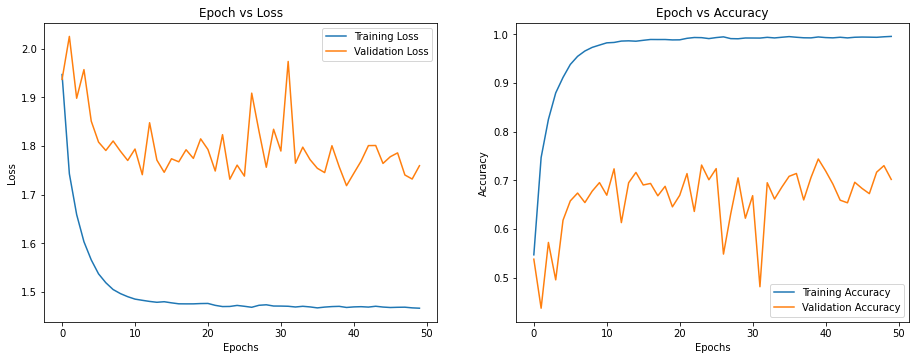

In [ ]:
# Run training.

net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 50)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

That did help it learn the training set faster, compared to a network with the same number of layers but the size was doubling at every layer, but it didn't change much with the validation set accuracy. Maybe I'll stick with this architecture and try applying other regularization tricks to it. 

### Data Augmentation with SpecAugment

In [ ]:
pip install torchaudio

     |████████████████████████████████| 1.9 MB 4.3 MB/s 


In [ ]:
# Data loading.
train_dir = "/content/train_cropped/"
val_dir =  "/content/val_cropped/"

train_dataset = datasets.DatasetFolder(
    train_dir, 
    extensions = (".pt"), 
    loader = torch.load, 
    transform = transforms.Compose([torchaudio.transforms.TimeMasking(time_mask_param= 10, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param=5, iid_masks=True)]) )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

val_dataset = datasets.DatasetFolder(
    val_dir, 
    extensions = (".pt"), 
    loader = torch.load )

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

In [ ]:
import torchaudio

In [ ]:
for data, target in train_dataset:
  print(target)
  print(data.shape)
  plt.figure()
  plt.imshow(data.numpy())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


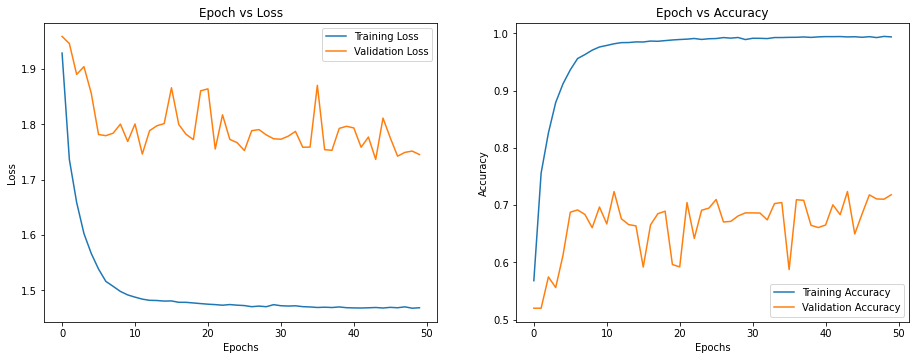

In [ ]:
# Run training.

net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 50)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

It seems that that level of masking really didn't have much effect at all. Maybe we need wider masking bands? I don't know how much we can push it really. I'll try again with much larger masks and fewer epochs just to see. 

In [ ]:
# Data loading.
train_dir = "/content/train_cropped/"
val_dir =  "/content/val_cropped/"

train_dataset = datasets.DatasetFolder(
    train_dir, 
    extensions = (".pt"), 
    loader = torch.load, 
    transform = transforms.Compose([torchaudio.transforms.TimeMasking(time_mask_param= 20, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param=20, iid_masks=True), 
                                    torchaudio.transforms.TimeMasking(time_mask_param= 20, iid_masks=True)]) )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

val_dataset = datasets.DatasetFolder(
    val_dir, 
    extensions = (".pt"), 
    loader = torch.load )

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


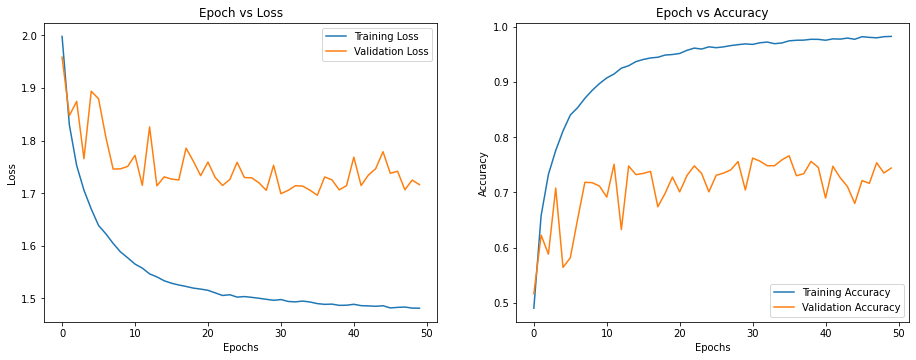

In [ ]:
# Run training.

net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 50)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

This does seem to have helped. The validation accuracy is now hovering around the mid 70s, not the low 70s it seems. Maybe we can push the masking even further. 

In [ ]:
# Data loading.
train_dir = "/content/train_cropped/"
val_dir =  "/content/val_cropped/"

train_dataset = datasets.DatasetFolder(
    train_dir, 
    extensions = (".pt"), 
    loader = torch.load, 
    transform = transforms.Compose([torchaudio.transforms.TimeMasking(time_mask_param= 40, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param=40, iid_masks=True), 
                                    torchaudio.transforms.TimeMasking(time_mask_param= 20, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param = 20, iid_masks=True)]) )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

val_dataset = datasets.DatasetFolder(
    val_dir, 
    extensions = (".pt"), 
    loader = torch.load )

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


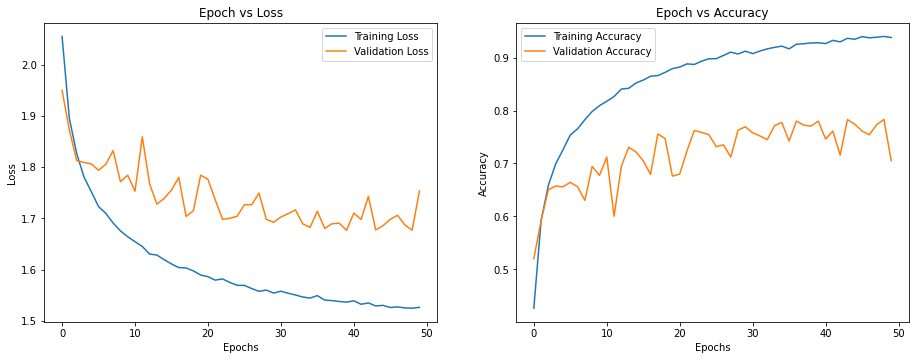

In [ ]:
# Run training.

net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 50)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

Looks like that is going even better! I'm not to increase the augmentation ***even more*** and also increase the learning rate slightly. 

In [ ]:
# Data loading.
train_dir = "/content/train_cropped/"
val_dir =  "/content/val_cropped/"

train_dataset = datasets.DatasetFolder(
    train_dir, 
    extensions = (".pt"), 
    loader = torch.load, 
    transform = transforms.Compose([torchaudio.transforms.TimeMasking(time_mask_param= 40, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param=40, iid_masks=True), 
                                    torchaudio.transforms.TimeMasking(time_mask_param= 30, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param = 30, iid_masks=True), 
                                    torchaudio.transforms.TimeMasking(time_mask_param= 20, iid_masks=True), 
                                    torchaudio.transforms.FrequencyMasking(freq_mask_param = 20, iid_masks=True)]) )

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

val_dataset = datasets.DatasetFolder(
    val_dir, 
    extensions = (".pt"), 
    loader = torch.load )

val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=100, shuffle=True, num_workers=0, drop_last = True)

In [ ]:
# Make a CNN & train it to predict genres.

class music_net(nn.Module):
  def __init__(self):
    """Intitalize neural net layers"""
    super(music_net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=0) # changed in channels to 1 
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=0)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=512, kernel_size=3, stride=1, padding=0)
    self.conv5 = nn.Conv2d(in_channels=512, out_channels=128, kernel_size=3, stride=1, padding=0)
    self.fc1 = nn.Linear(in_features=512, out_features=10) ##################################### changed in_features

    self.batchnorm1 = nn.BatchNorm2d(num_features=16)
    self.batchnorm2 = nn.BatchNorm2d(num_features=64)
    self.batchnorm3 = nn.BatchNorm2d(num_features=128)
    self.batchnorm4 = nn.BatchNorm2d(num_features=512)
    self.batchnorm5 = nn.BatchNorm2d(num_features=128)

    self.dropout = nn.Dropout(p=0.3, inplace=False)


  def forward(self, x):
    # Conv layer 1.
    x = self.conv1(x)
    x = self.batchnorm1(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 2.
    x = self.conv2(x)
    x = self.batchnorm2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 3.
    x = self.conv3(x)
    x = self.batchnorm3(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 4.
    x = self.conv4(x)
    x = self.batchnorm4(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)

    # Conv layer 5.
    x = self.conv5(x)
    x = self.batchnorm5(x)
    x = F.relu(x)
    x = F.max_pool2d(x, kernel_size=2)
    #print(x.shape)################################################################

    # Fully connected layer 1.
    x = torch.flatten(x, 1)
    x = self.dropout(x)
    x = self.fc1(x)
    x = F.softmax(x)

    return x


def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device), target.to(device)
        
        #squeeze out extra dimension in data
        #data = data.squeeze(dim = 0) ########################################### this is new. 

        #using torch dataloader, you have to unsqueeze the data, I think...
        data = data.reshape((100, 1, 128, 129))#######  this is hardcoded for now and should be fixed somewhere else. 
        #100 is the batch size, 1 is for a single channel, and 128 by 129 is the size of the spectrogram image in pixels. 

        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        #using torch dataloader, you have to unsqueeze the data, I think...
        data = data.reshape((100, 1, 128, 129))#######  this is hardcoded for now and should be fixed somewhere else. 
        #100 is the batch size, 1 is for a single channel, and 128 by 129 is the size of the spectrogram image in pixels. 

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)

  return train_loss, train_acc, validation_loss, validation_acc

In [ ]:
# Run training.

net = music_net().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader, val_loader, 50)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
